# **Prediction of Lane-Changing Maneuvers on European Highways**
##### The lane changing maneuver have been collected from the [HighD trajectory dataset](https://www.highd-dataset.com/). The lane-changing maneuver prediction can be done in the right lane (overtaking maneuver) or in the left lane (fold-down). Indeed, the European Driving Code requires using the left lane only for overtaking maneuvers.
##### We compare different classification algorithms and machine learning techniques. Predictions are carried out using cross-validation and bootstrap sampling.
##### See https://www.sciencedirect.com/science/article/abs/pii/S0378437123000262 for details.

In [ ]:
## Install the packages (it may take a few minutes)

install.packages('neuralnet');require(neuralnet)
install.packages('MASS');require(MASS)
install.packages('corrplot');require(corrplot)
install.packages('rpart');require(rpart)
install.packages('rpart.plot');require(rpart.plot)
install.packages('e1071');require(e1071)
install.packages('randomForest');require(randomForest)
install.packages('LPCM');require(LPCM)
install.packages('GGally');library(GGally)


In [ ]:
## Download the data

download.file('https://raw.githubusercontent.com/antoinetordeux/Datasets/main/LaneChanging-2.txt','/content/LaneChanging.txt')


In [ ]:
## Read the data

data=read.table("LaneChanging.txt",header=TRUE)
names(data);attach(data)

Y=maneuver>2		# Maneuver:  1:LKR 2:LKL 3:LCR 4:LCL
X=cbind(distPred,distFollo,distPredAdj,distFolloAdj,diffSpeedPred,diffSpeedFollo,diffSpeedPredAdj,diffSpeedFolloAdj)
cc=maneuver%in%c(1,4)&class==1;Yr=Y[cc];Xr=as.data.frame(scale(X[cc,]))  # right lane
cc=maneuver%in%c(2,3)&class==1;Yl=Y[cc];Xl=as.data.frame(scale(X[cc,]))  # left lane


[1] "maneuver"          "xVelocity"         "yVelocity"        
 [4] "xAcceleration"     "yAcceleration"     "class"            
 [7] "distPred"          "diffSpeedPred"     "timeGapPred"      
[10] "accPred"           "classPred"         "distFollo"        
[13] "diffSpeedFollo"    "timeGapFollo"      "accFollo"         
[16] "classFollo"        "distPredAdj"       "diffSpeedPredAdj" 
[19] "timeGapPredAdj"    "accPredAdj"        "classPredAdj"     
[22] "distFolloAdj"      "diffSpeedFolloAdj" "timeGapFolloAdj"  
[25] "accFolloAdj"       "classFolloAdj"

## **Preliminary Data Analysis**

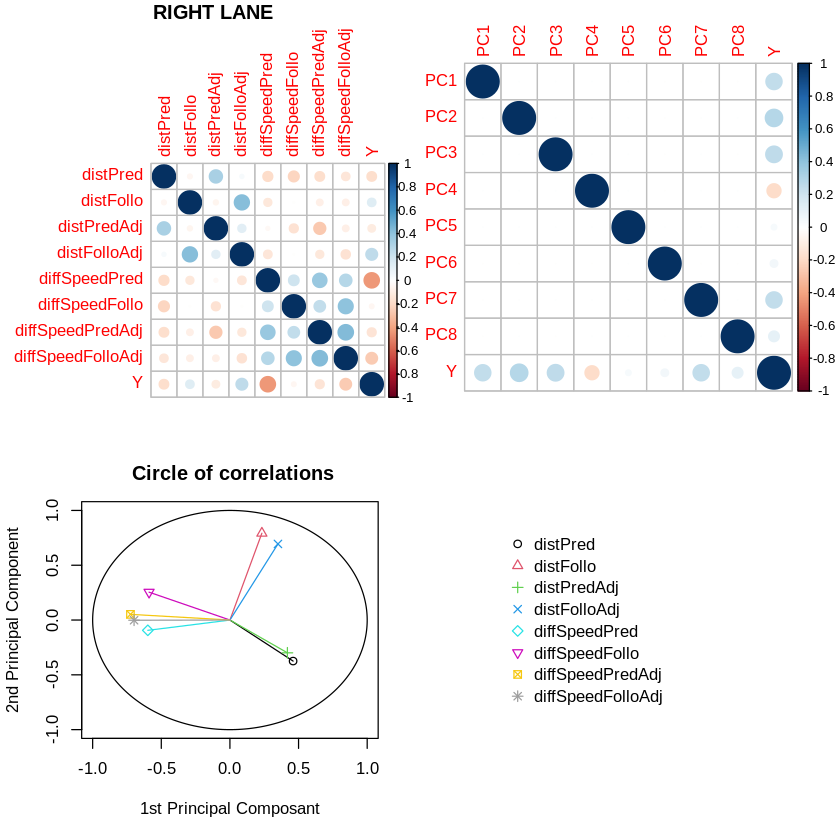

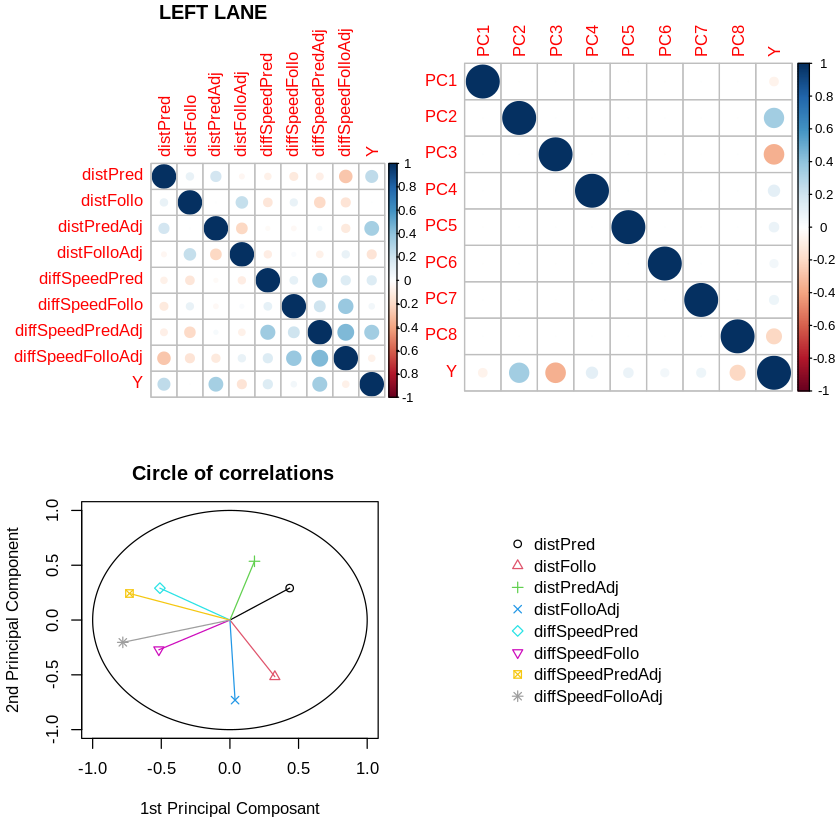

In [ ]:
## Correlation and principal component analysis

X=Xr;Y=Yr
for(lane in c("RIGHT LANE","LEFT LANE")){
  par(mfrow=c(2,2))
  corrplot(cor(cbind(X,Y)),main=paste("\n",lane))

  Z=prcomp(X)
  corrplot(cor(cbind(Z$x,Y)))

  plot(cos(seq(0,2*pi,.01)),sin(seq(0,2*pi,.01)),main="\n Circle of correlations",xlab="1st Principal Composant",ylab="2nd Principal Component",type='l',xlim=c(-1,1),ylim=c(-1,1))
  for(i in 1:length(cor(X,Z$x)[,2])){
    segments(0,0,cor(X,Z$x)[i,1],cor(X,Z$x)[i,2],col=i)
  	lines(cor(X,Z$x)[i,1],cor(X,Z$x)[i,2],type='p',pch=i,col=i)}
	cc=1:ncol(X);
  plot(NA,xlim=c(0,1),ylim=c(0,1),xlab="",ylab="",axes=F)
  legend("left",names(X)[cc],pch=cc,col=cc,cex=1,bty='n')
	X=Xl;Y=Yl}


## **Logistic Analysis**

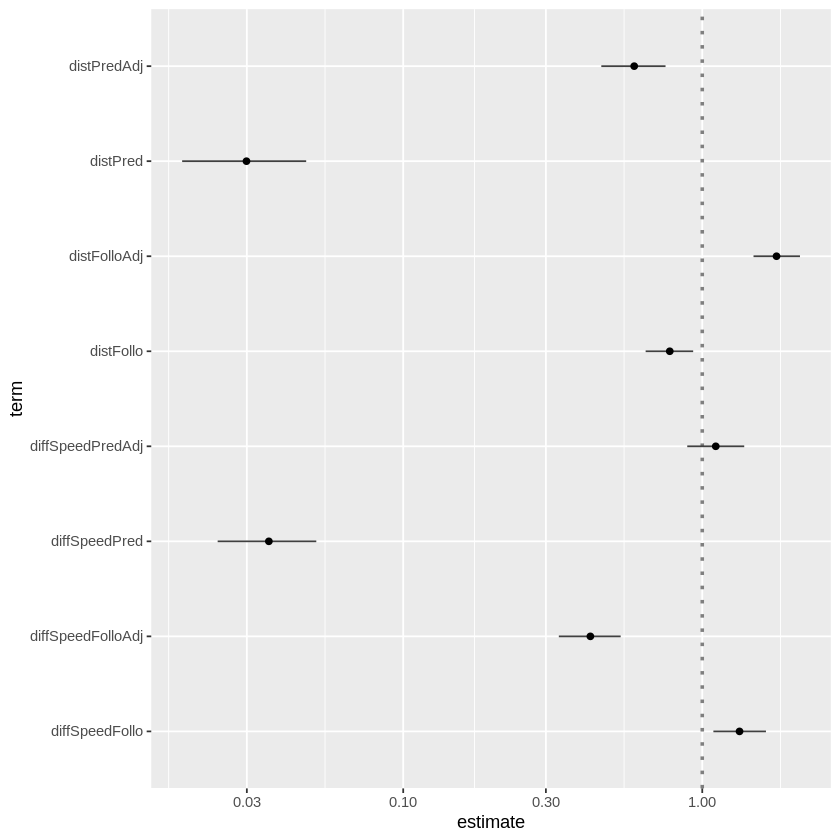

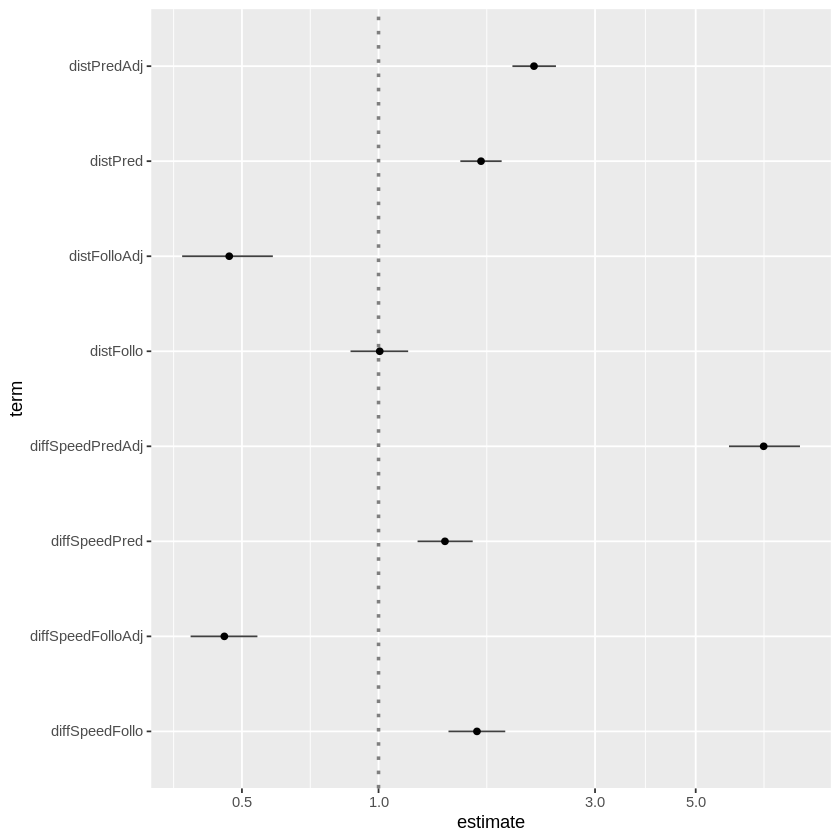

In [ ]:
## Logistic regression on the normed dataset

options(warn=-1)
regR=glm(Yr~.,data=Xr,family=binomial(logit))
ggcoef(regR,exponentiate=T,exclude_intercept=T)
regR=glm(Yl~.,data=Xl,family=binomial(logit))
ggcoef(regR,exponentiate=T,exclude_intercept=T)

## **Lane-Changing Prediction by Bootstrap Cross-Validation using Different Algorithms**

In [ ]:
## Helpful functions

MSE=function(M,Y)
	mean((M-Y)^2)
algo_names=function()
 	axis(1,at=1:7,lab=c("REG","LDA","NB","DT","NN","RF","SVM"))


In [ ]:
## Principal components as explanatory variables

PCr=as.data.frame(prcomp(Xr)$x)
PCl=as.data.frame(prcomp(Xl)$x)


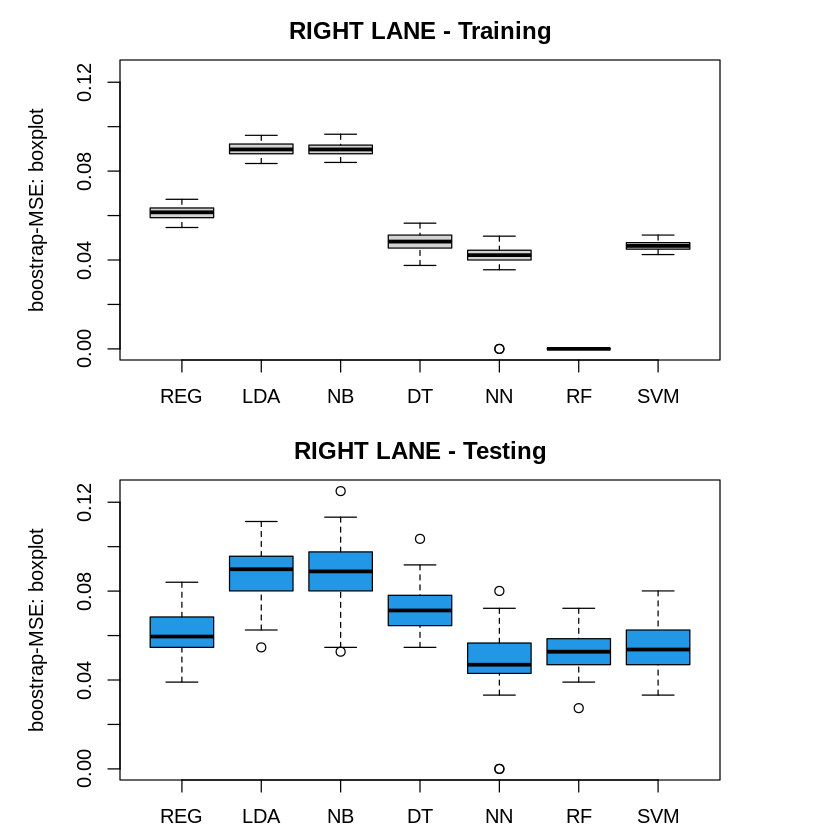

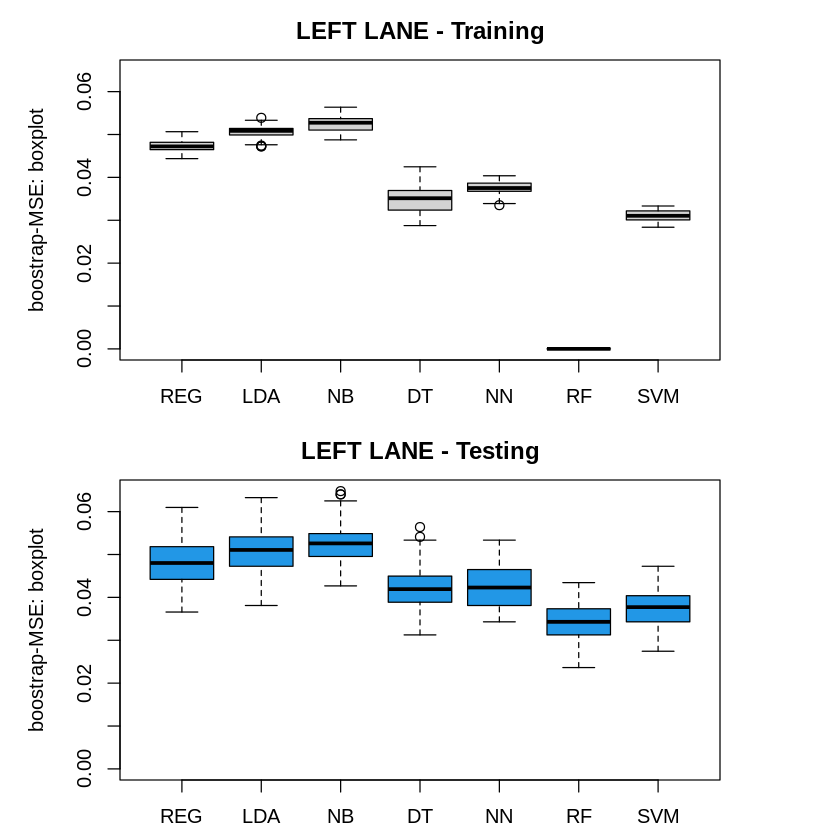

In [ ]:
## Prediction by boostrap and cross-validation. B is the number of boostrap subsamples.

B=50
X=Xr;Y=Yr;PC=PCr
for(lane in c("RIGHT LANE","LEFT LANE")){
  Rtrain=matrix(0,B,7)
  Rtest=matrix(0,B,7)
  for(b in 1:B){

## Cross-validation
	  cc=NULL;n=nrow(X)
	  cc[1:n]=T;cc[sample(1:n,.2*n)]=F

## Logistic regression
	  algo_REG=glm(Y[cc]~.,data=PC[cc,],family=binomial(logit))
	  Rtrain[b,1]=MSE(predict(algo_REG,PC[cc,])>0,Y[cc])
	  Rtest[b,1]=MSE(predict(algo_REG,PC[!cc,])>0,Y[!cc])

## Linear discriminant analysis
	  algo_LDA=lda(Y[cc]~.,data=PC[cc,])
	  Rtrain[b,2]=MSE(as.numeric(predict(algo_LDA,PC[cc,])$class)-1,Y[cc])
	  Rtest[b,2]=MSE(as.numeric(predict(algo_LDA,PC[!cc,])$class)-1,Y[!cc])

## Naive-Bayes
		algo_NB=naiveBayes(as.factor(Y[cc])~.,data=PC[cc,])
	  Rtrain[b,3]=MSE(as.numeric(predict(algo_NB,PC[cc,],type="class"))-1,Y[cc])
	  Rtest[b,3]=MSE(as.numeric(predict(algo_NB,PC[!cc,],type="class"))-1,Y[!cc])

## Decision tree
	  algo_DT=rpart(Y[cc]~.,data=X[cc,],method="class")
	  Rtrain[b,4]=MSE(as.numeric(predict(algo_DT,X[cc,],type="class"))-1,Y[cc])
	  Rtest[b,4]=MSE(as.numeric(predict(algo_DT,X[!cc,],type="class"))-1,Y[!cc])

## Neural network
	  algo_NN=neuralnet(Y[cc]~.,data=PC[cc,],linear.out=F,h=c(2),err.fct="sse",threshold=.01)
		if(!is.null(algo_NN$result.matrix)&&MSE(round(predict(algo_NN,PC[cc,]))[,1],Y[cc])>0){
  	  Rtrain[b,5]=MSE(round(predict(algo_NN,PC[cc,]))[,1],Y[cc])
  	  Rtest[b,5]=MSE(round(predict(algo_NN,PC[!cc,]))[,1],Y[!cc])}

## Random forest
	  algo_RF=randomForest(as.factor(Y[cc])~.,data=X[cc,])
	  Rtrain[b,6]=MSE(as.numeric(predict(algo_RF,X[cc,]))-1,Y[cc])
	  Rtest[b,6]=MSE(as.numeric(predict(algo_RF,X[!cc,]))-1,Y[!cc])

## Support vector machine
	  algo_SVM=svm(as.factor(Y[cc])~.,data=PC[cc,])
	  Rtrain[b,7]=MSE(as.numeric(predict(algo_SVM,PC[cc,]))-1,Y[cc])
	  Rtest[b,7]=MSE(as.numeric(predict(algo_SVM,PC[!cc,]))-1,Y[!cc])}

## Plot of the results
	par(mfrow=c(2,1));par(mar=c(2.5,5,2.5,5))
	boxplot(Rtrain,xlab="",ylab="boostrap-MSE: boxplot",xaxt='n',ylim=range(Rtrain,Rtest),main=paste(lane,"- Training"));algo_names()
	boxplot(Rtest,xlab="",ylab="boostrap-MSE: boxplot",xaxt='n',ylim=range(Rtrain,Rtest),col=4,main=paste(lane,"- Testing"));algo_names()
	X=Xl;Y=Yl;PC=PCl}


##### Author: Antoine Tordeux, Bergische Universität Wuppertal ([vzu.uni-wuppertal.de](https://www.vzu.uni-wuppertal.de/en/))